## Feature Extaction Test

In [52]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from feature_extraction.feature_extraction import CandidatesFeatureExtraction, CandidatesFeatureExtraction_MP
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from metrics.metrics import quick_circle_comparison, circle_comparison
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria
from general_utils.plots import plot_gabor_filters

from mc_candidate_proposal.candidate_utils import balance_candidates

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from metrics.metrics_utils import (get_froc_df_of_img, get_froc_df_of_many_imgs_features,
                                   get_tp_fp_fn_center_patch_criteria)


from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap

### Database initialization

In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

### Detectors Parameters and initialization

In [3]:
hd = HoughCalcificationDetection()


### Detector initialization

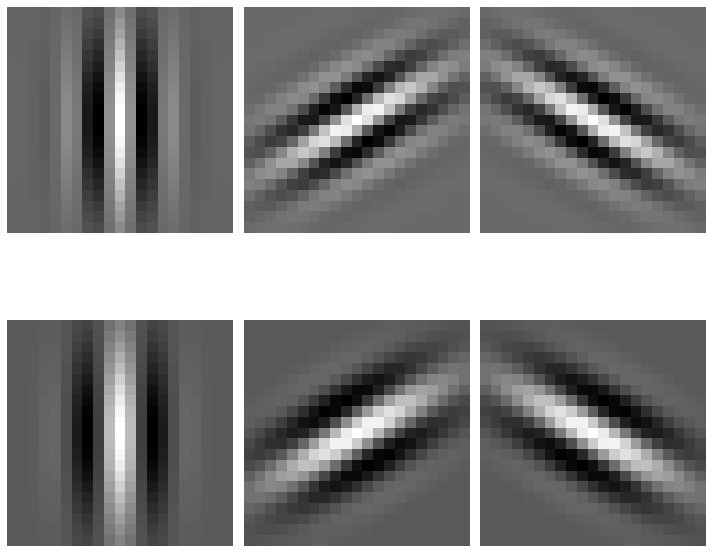

In [4]:
# FE class initialization
GABOR_PARAMS = {'scale': 2, 'orientation': 3,
                'max_freq': 0.2, 'ksize': (20, 20), 'sigma': 3}
cfe  = CandidatesFeatureExtraction_MP(patch_size=14, gabor_params=GABOR_PARAMS, fos=False, haar_params=None, wavelet_params=None)
gabor_fb = cfe.gabor_feature_bank(**GABOR_PARAMS)
plot_gabor_filters(gabor_fb)


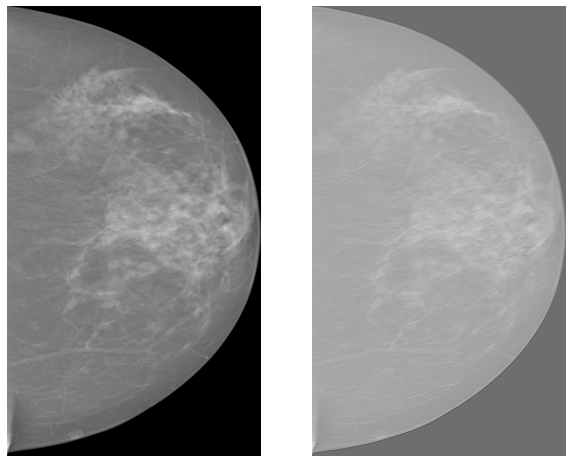

In [5]:
image = db[0]['img']
simple_im_show2(image, cv2.filter2D(image, cv2.CV_32F, gabor_fb[3]))

In [67]:
train_img_ids =  list(set(np.random.randint(0, 140, 70, )))[:50]
validation_img_ids = train_img_ids[:10]

In [ ]:
# FE
for idx in tqdm(train_img_ids):
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    image_mask = db_sample['lesion_mask']
    muscle_mask = db_sample['muscle_mask']
    #
    # candidate detection
    candidates = hd.detect(
        image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

    # labeling of candidates:
    tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, None, 14)
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

    # Balancing the candidates
    candidates = balance_candidates(candidates, fp2tp_sample=10)

    # Extracting features
    labels = np.where(candidates.label.values == 'TP', True, False)
    
    # Avoid extracting features for repeted detections
    X = candidates.drop_duplicates(subset='repeted_idxs')

### FE

In [31]:
train_img_ids =  list(set(np.random.randint(0, 140, 70, )))[:50]
validation_img_ids = train_img_ids[:10]

GABOR FEATURE BANK WITH SCALE-2 ORIENTATION-3


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


<IPython.core.display.Javascript object>

Auc test: 0.8661376393694732


/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


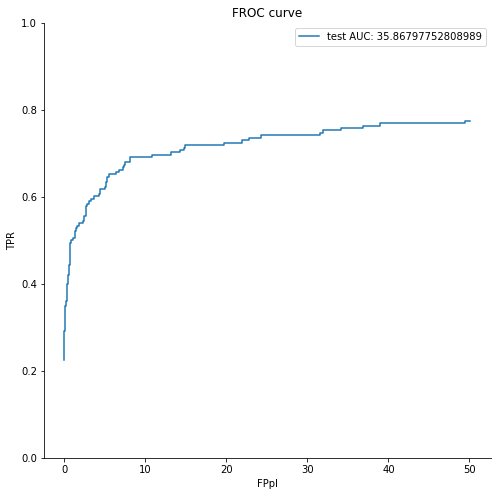

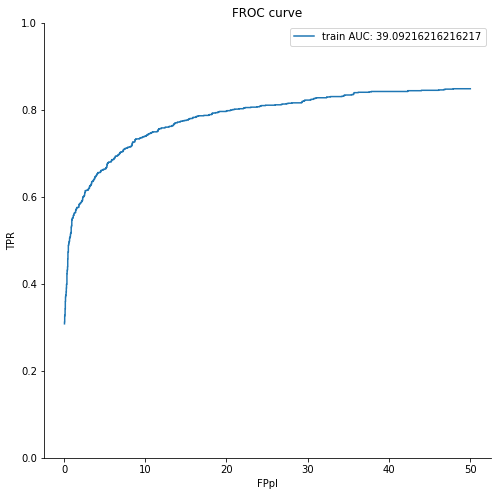

GABOR FEATURE BANK WITH SCALE-3 ORIENTATION-5


100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


<IPython.core.display.Javascript object>

Auc test: 0.9290226835832371


/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


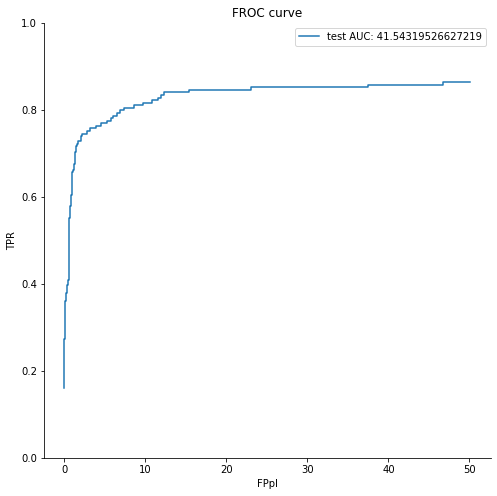

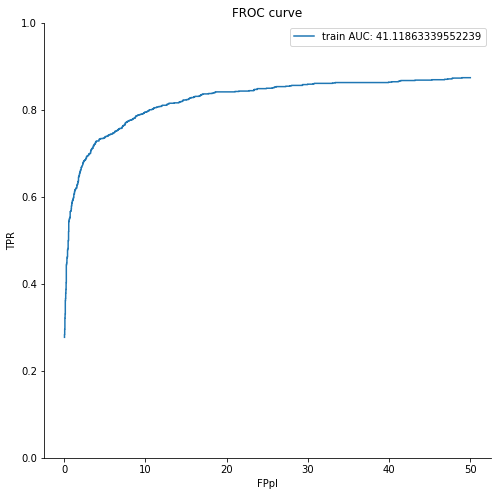

GABOR FEATURE BANK WITH SCALE-4 ORIENTATION-6


  6%|▌         | 3/50 [00:12<03:10,  4.05s/it]Process ForkPoolWorker-2468:
Process ForkPoolWorker-2469:
Process ForkPoolWorker-2471:
Process ForkPoolWorker-2472:
Process ForkPoolWorker-2470:
Process ForkPoolWorker-2466:
Process ForkPoolWorker-2467:
  6%|▌         | 3/50 [00:15<04:09,  5.32s/it]


KeyboardInterrupt: 

In [66]:
for s,o in [(2,3), (3,5), (4,6), (5,8)]:
    print(f"GABOR FEATURE BANK WITH SCALE-{s} ORIENTATION-{o}")

    GABOR_PARAMS = {'scale': s, 'orientation': o,
                    'max_freq': 0.2, 'ksize': (20, 20), 'sigma': 3}
    cfe  = CandidatesFeatureExtraction_MP(patch_size=14, gabor_params=GABOR_PARAMS, fos=False, haar_params=None, wavelet_params=None)


    idx = 0
    fdf = []
    fnsdf = []

    # FE
    for idx in tqdm(train_img_ids):
        # extracting data
        db_sample = db[idx]
        image = db_sample['img']
        image_id = db_sample['img_id']
        image_mask = db_sample['lesion_mask']
        muscle_mask = db_sample['muscle_mask']
        #
        # candidate detection
        candidates = hd.detect(
            image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

        # labeling of candidates:
        tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
            candidates, image_mask, None, 14)
        candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

        # Balancing the candidates
        candidates = balance_candidates(candidates, fp2tp_sample=10)

        # Extracting features
        labels = np.where(candidates.label.values == 'TP', True, False)
        
        # Avoid extracting features for repeted detections
        X = candidates.drop_duplicates(subset='repeted_idxs')
        X = cfe.extract_features(X.loc[:,['x','y','radius']].values.astype(int), image)

        # Get features dfs
        X = pd.DataFrame(data=X, columns=cfe.feature_names)
        X.index = candidates.drop_duplicates(subset='repeted_idxs').index

        res = X.loc[candidates.repeted_idxs.tolist(),:]
        res['img_id'] = image_id
        res['repeted_idxs'] = candidates.repeted_idxs.tolist()
        res['matching_gt'] = candidates.matching_gt.tolist()
        res['label'] = labels

        # Generate a fn dataframe to compute frocs
        fn['img_id'] = image_id
        fnsdf.append(fn)
        fdf.append(res)
        
    all_data_df = pd.concat(fdf)#.sample(frac=1) # merge and shuffle
    fns_df = pd.concat(fnsdf, ignore_index=True)

    gabor_cols = [x for x in all_data_df.columns if 'gabor' in x]


    validation_img_indxs = all_data_df.img_id.unique()[:10]
    test_mask = all_data_df.img_id.isin(validation_img_indxs)

    train_df = all_data_df[~test_mask]
    train_fns_df = fns_df[~fns_df.img_id.isin(validation_img_indxs)]

    test_df = all_data_df[test_mask]
    test_fns_df = fns_df[fns_df.img_id.isin(validation_img_indxs)]


    train_X, train_y = train_df[gabor_cols].values, train_df.label.values.astype(int)
    test_X, test_y = test_df[gabor_cols].values, test_df.label.values.astype(int)

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    svc = SVC(C=10, probability=True)
    svc.fit(train_X_scaled, train_y)

    train_y_predicted = svc.predict_proba(train_X_scaled)[:,1]

    test_y_predicted = svc.predict_proba(test_X_scaled)[:,1]   
    # doing prediction of ALL test candidates


    auc_test = roc_auc_score(test_y, test_y_predicted)

    print(f'Auc test: {auc_test}')

    froc_df = get_froc_df_of_many_imgs_features(
        test_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
        test_fns_df,
        test_y_predicted
    )

    froc_df_train = get_froc_df_of_many_imgs_features(
        train_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
        train_fns_df,
        train_y_predicted
    )

    sens, avgs_fp_per_image, _ = froc_curve(froc_df, non_max_supression=True, cut_on_50fpi=True)
    plot_froc(avgs_fp_per_image, sens, label='test')

    sens, avgs_fp_per_image, _ = froc_curve(froc_df_train, non_max_supression=True, cut_on_50fpi=True)
    plot_froc(avgs_fp_per_image, sens, label='train')
    

In [65]:
froc_df_train

,x,y,radius,detection_labels,pred_scores,img_id,matching_gt,repeted_idxs,pred_binary,class_labels
0,26,1362,7.0,TP,0.996590,20587492,93.0,0,False,False
1,581,919,5.0,TP,0.586278,20587492,31.0,1,False,False
2,595,1264,9.0,TP,0.986814,20587492,45.0,2,False,False
3,432,1101,9.0,TP,0.086468,20587492,78.0,3,False,False
4,461,1202,9.0,TP,1.000000,20587492,69.0,4,False,False
...,...,...,...,...,...,...,...,...,...,...
19194,912,1850,0.0,FN,0.000000,24055274,None,False,False,False
19195,919,1848,0.0,FN,0.000000,24055274,None,False,False,False
19196,817,3730,0.0,FN,0.000000,24055464,None,False,False,False
19197,614,2694,0.0,FN,0.000000,24055600,None,False,False,False


### Classification

Mostly to check how extracted features work

In [16]:
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler

In [17]:
all_data_df = pd.concat(fdf).sample(frac=1) # merge and shuffle
data = all_data_df#.drop(columns=['candidate_coordinates', 'patch_coordinates'])
data

,gabor_energy_0,gabor_max_0,gabor_min_0,gabor_mean_0,gabor_std_0,gabor_skew_0,gabor_kurt_0,gabor_energy_1,gabor_max_1,gabor_min_1,...,gabor_mean_5,gabor_std_5,gabor_skew_5,gabor_kurt_5,candidate_coordinates,patch_coordinates,img_id,repeted_idxs,matching_gt,label
282,5.743088,0.427734,-0.239762,0.078924,0.151896,0.478765,0.088164,1040.941406,3.02422,1.925671,...,2.352921,0.193644,-0.370623,-0.856283,"[326, 837, 9]","((830, 844), (319, 333))",20587492,282,NaN,False
2321,0.834657,0.168745,-0.105614,0.031755,0.057009,-0.196543,-0.388565,273.391327,1.331246,0.978301,...,1.186311,0.063107,-0.252705,-0.763286,"[802, 2474, 4]","((2467, 2481), (795, 809))",22678495,2321,NaN,False
2220,1.154673,0.187221,-0.114706,0.043248,0.06341,-0.175462,-0.20876,371.93219,1.584815,1.042267,...,1.39367,0.113715,-0.024312,-0.743037,"[543, 25, 2]","((18, 32), (536, 550))",22580068,2220,NaN,False
16,4.704731,0.392319,-0.249222,0.059472,0.143062,0.117474,-0.13225,833.157715,2.479962,1.594096,...,2.040151,0.406032,0.215408,-0.689119,"[646, 2202, 6]","((2195, 2209), (639, 653))",24055752,16,114.0,True
1881,1.215825,0.156072,-0.111671,0.035028,0.070543,-0.17346,-1.068868,326.791351,1.504182,1.02473,...,1.328054,0.095929,-0.859828,0.887467,"[290, 1400, 3]","((1393, 1407), (283, 297))",22678495,1881,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2.269984,0.266659,-0.224858,0.025038,0.104664,0.296126,-0.539116,523.44812,1.964358,1.184243,...,1.835425,0.194643,1.067152,0.860967,"[585, 831, 8]","((824, 838), (578, 592))",22670124,4,2.0,True
330,1.186482,0.208289,-0.08768,0.045682,0.062982,-0.114415,-0.491095,398.391846,1.586268,1.220717,...,1.452288,0.051327,-0.313127,-0.244926,"[895, 1805, 5]","((1798, 1812), (888, 902))",24055382,330,NaN,False
1268,1.288184,0.309172,-0.128952,0.043576,0.068363,0.350832,1.862294,475.148438,1.851381,1.331789,...,1.575385,0.14224,-0.020029,0.059196,"[684, 2157, 8]","((2150, 2164), (677, 691))",22678518,1268,NaN,False
2659,3.21052,0.281897,-0.163599,0.061826,0.112061,0.12786,-0.94591,992.75,2.775631,1.8406,...,2.3566,0.237962,-0.086678,-0.744175,"[1143, 1386, 3]","((1379, 1393), (1136, 1150))",24055752,2659,NaN,False


In [18]:
gabor_cols = [x for x in data.columns if 'gabor' in x]

Resampling data to 1:1 split for TP/FP for a nice training

In [12]:
f1_metrics = []
rocauc_metrics = []

test_image_ids = test_imgs[:20]
full_test_prediction = []

test_img_ids = db.df[db.df.img_id].img_id.values
test_mask = data.img_id.isin(test_img_ids)

train_df = data[~test_mask]
test_df = data[test_mask]

train_X, train_y = train_df.drop(columns=['patch_mask_intersection', 'img_id']), (train_df.patch_mask_intersection>0).values.astype(int)
test_X, test_y = test_df.drop(columns=['patch_mask_intersection', 'img_id']), (test_df.patch_mask_intersection>0).values.astype(int)

scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

svc = SVC(C=10, probability=False)
svc.fit(train_X_scaled, train_y)

train_y_predicted = svc.predict(train_X_scaled)

test_y_predicted = svc.predict(test_X_scaled)    

f1_metrics.append((f1_score(train_y, train_y_predicted), f1_score(test_y, test_y_predicted)))

# doing prediction of ALL test candidates
all_test_candidates = data_backed_up[data_backed_up.img_id.isin(test_img_ids)]
all_test_X, all_test_y = all_test_candidates.drop(columns=['patch_mask_intersection', 'img_id']), (all_test_candidates.patch_mask_intersection>0).values.astype(int)
all_test_X_scaled = scaler.transform(all_test_X)
all_test_y_predicted = svc.predict(all_test_X_scaled)
full_test_prediction.append((all_test_y, all_test_y_predicted))


100%|██████████| 50/50 [02:03<00:00,  2.47s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

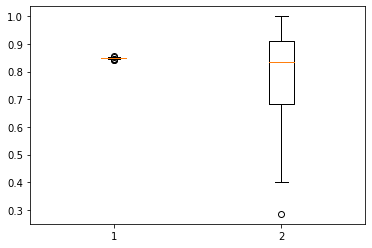

In [13]:
plt.boxplot(np.array(f1_metrics))
plt.show()

<IPython.core.display.Javascript object>

(array([ 1.,  2.,  0.,  2.,  5.,  5.,  7.,  6., 11., 11.]),
 array([0.28571429, 0.35714286, 0.42857143, 0.5       , 0.57142857,
        0.64285714, 0.71428571, 0.78571429, 0.85714286, 0.92857143,
        1.        ]),
 <BarContainer object of 10 artists>)

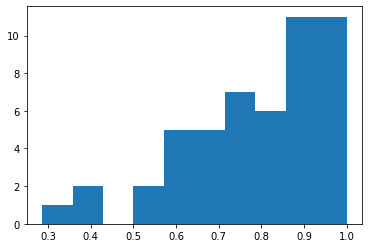

In [14]:
plt.hist(np.array(f1_metrics)[:,1])

In [15]:
np.median(np.array(f1_metrics)[:,1])

0.8345771144278606

In [16]:
def sensitivity(y_true, y_pred):
    TP = np.sum(y_true & y_pred)
    FN = np.sum(y_true&(~y_pred))
    if TP + FN == 0:
        return 0
    return TP/(TP + FN)

F1 0.8615134886350362 0.9393382352941176


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

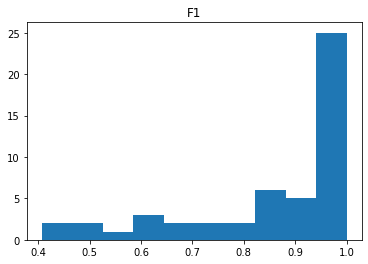

#FP 292.66 212.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

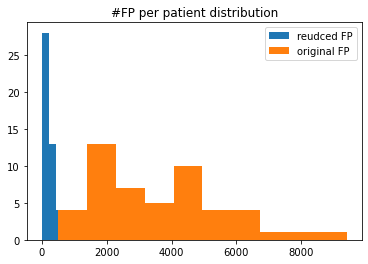

In [17]:
all_f1 = [sensitivity(x, y) for x, y in full_test_prediction]
print('F1', np.mean(all_f1), np.median(all_f1))
plt.hist(all_f1)
plt.title('F1')
plt.show()


FP_number_reduced = [np.sum(y&(~x)) for x, y in full_test_prediction]
FP_number_original = [len(y) - np.sum(x) for x, y in full_test_prediction]
print('#FP', np.mean(FP_number_reduced), np.median(FP_number_reduced))
plt.title('#FP per patient distribution')
plt.hist(FP_number_reduced)
plt.hist(FP_number_original)
plt.legend(['reudced FP', 'original FP'])
plt.show()

## Some feature testing drafts (ignore)

### Gabor

In [9]:
from general_utils.utils import min_max_norm
from skimage import feature

In [10]:
image = db[0]['img']
# not sure if agnles are what I need to get left<->right with d=2
image_patch = min_max_norm(image[300:330, 330:360], max_val=255).astype(np.uint8) # needs conversion for GLCM generation

In [11]:
def gabor_feature_bank(scale, orientation, max_freq=0.2, ksize=(50, 50), sigma=1):
    orientations = [(i*np.pi)/orientation for i in range(orientation)]
    frequencies = [(max_freq)/(np.sqrt(2)**i) for i in range(scale)]
    gabor_kernels = []
    for orient in orientations:
        for freq in frequencies:
            gabor_kernels.append(cv2.getGaborKernel(ksize=ksize, sigma=sigma, theta=orient, lambd=1/freq, gamma=0.5, psi=0))
    
    return gabor_kernels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

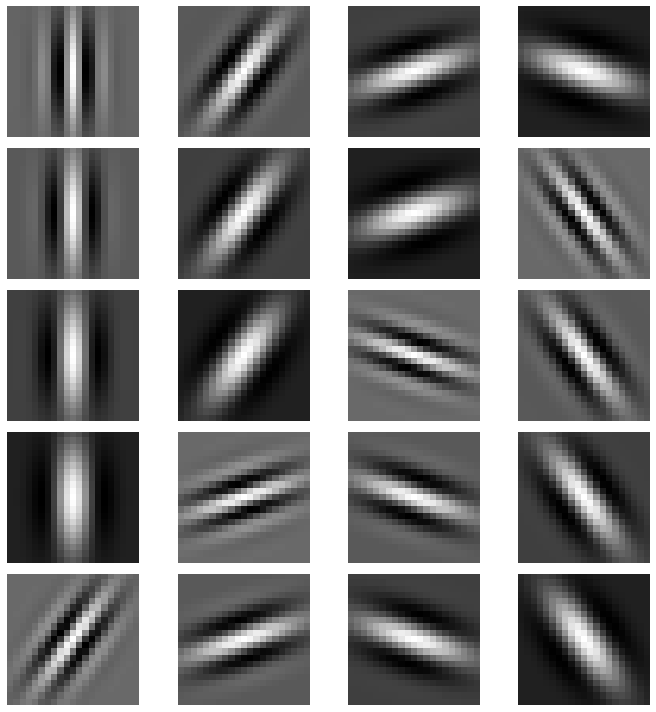

In [9]:
kerns = gabor_feature_bank(scale=4, orientation=5, max_freq=0.2, ksize=(20, 20), sigma=3)
plot_gabor_filters(kerns, plots_columns=4)

In [12]:
def gabour_features(image, patch_coords, gabor_params):
    gabor_kernels = gabor_feature_bank(**gabor_params)
    features = {}
    for kidx, k in enumerate(gabor_kernels):
        filtered_image = cv2.filter2D(image, ddepth=cv2.CV_32F , kernel=k)
        
        gf = CandidatesFeatureExtraction.first_order_statistics(filtered_image[patch_coords[0][0]:patch_coords[0][1],
                                                                               patch_coords[1][0]:patch_coords[1][1]],
                                                                flag=f'g{kidx}')  
        features = features | gf
    return features

In [13]:
gabour_features(image, [(100, 110), (200, 220)], gabor_params)

{'img_energyg0': 5346411.0,
 'img_entropyg0': 7.643856189774659,
 'img_uniformityg0': 0.005000000000000001,
 'img_ming0': -91.93469,
 'img_10th_percg0': -51.36944580078124,
 'img_90th_percg0': 267.2617645263672,
 'img_maxg0': -51.36944580078124,
 'img_meang0': 109.50778,
 'img_meadiang0': 110.487946,
 'img_inter_quartile_rangeg0': 148.52622318267822,
 'img_rangeg0': 40.56524658203126,
 'img_mean_abs_deviationg0': 94.7519921875,
 'img_robust_mean_abs_deviationg0': 66.30067138671875,
 'img_rmsg0': 163.49940366863729,
 'img_stdg0': 121.40881,
 'img_skewg0': 0.45761913350027317,
 'img_kurtg0': -0.1294826345846003,
 'img_energyg1': 2762324200.0,
 'img_entropyg1': 7.643856189774659,
 'img_uniformityg1': 0.005000000000000001,
 'img_ming1': 3276.7466,
 'img_10th_percg1': 3467.05166015625,
 'img_90th_percg1': 4004.3506103515624,
 'img_maxg1': 3467.05166015625,
 'img_meang1': 3710.8289,
 'img_meadiang1': 3699.3433,
 'img_inter_quartile_rangeg1': 262.61328125,
 'img_rangeg1': 190.3050781249999,
 

### LBP

In [93]:
from skimage.feature import local_binary_pattern

In [98]:
image_patch = image[200:300, 300:400]

In [ ]:
lbp_params = {'P':16, 'R':14, 'method':'uniform'}

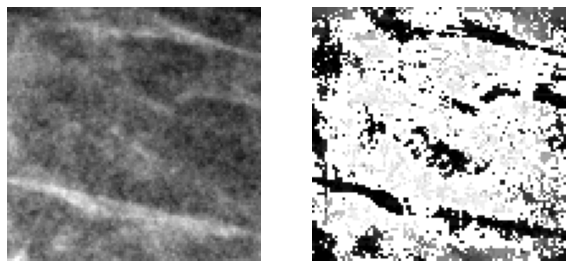

In [107]:
simple_im_show2(image_patch, local_binary_pattern(image_patch, P=16, R=14, method='uniform'))